In [1]:
import os
import json
import numpy as np

# Strategy:
# Extract pos_ner + embeddings & rolling embeddings
# Flag bad ner, use POS to get the numbers and potential other bad stuff
# Project embeddings & rolling embeddings, cosine sim with all other clusters ?
# Then rules for numbers

text_path = '../example_conversations/english/labelled_text_conv_1.json'

with open(text_path, 'r') as f:
    labelled_data = json.load(f)


In [2]:
unlabelled_data = [list(i.keys())[0] for i in labelled_data]

In [3]:
from pos_ner import get_pos, get_ner, get_pos_2

pos = get_pos_2(unlabelled_data)
ner, entities = get_ner(unlabelled_data)

2025-06-16 19:16:44,241 SequenceTagger predicts: Dictionary with 17 tags: NOUN, PUNCT, ADP, VERB, ADJ, DET, PROPN, ADV, PRON, AUX, CCONJ, NUM, SCONJ, PART, X, SYM, INTJ


Device set to use cuda:0
/home/nizar/PycharmProjects/DE-ID/venv1/lib/python3.12/site-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [4]:
fit_data = [[i, 0] for i in unlabelled_data]

for i, c in enumerate(ner):
    word, label = c
    assert fit_data[i][0] == word, f'Unmatched words in NER and data: position {i} ; word: {word} ; data: {fit_data[i]}'

    if label != '0':
        fit_data[i][1] = 1


In [5]:
len(pos), len(fit_data)

(385, 385)

In [6]:
fit_data

[['Hi', 0],
 ['can', 0],
 ['you', 0],
 ['believe', 0],
 ['the', 0],
 ['bus', 0],
 ['was', 0],
 ['late', 0],
 ['again', 0],
 ['this', 0],
 ['morning', 0],
 ['Yeah', 0],
 ['it’s', 0],
 ['always', 0],
 ['Line', 0],
 ['25', 0],
 ['I', 0],
 ['was', 0],
 ['supposed', 0],
 ['to', 0],
 ['be', 0],
 ['at', 0],
 ['4', 1],
 ['Place', 1],
 ['du', 1],
 ['Marché', 1],
 ['by', 0],
 ['8h30', 0],
 ['Did', 0],
 ['you', 0],
 ['see', 0],
 ['that', 0],
 ['new', 0],
 ['café', 0],
 ['on', 0],
 ['Rue', 1],
 ['de', 1],
 ['la', 1],
 ['Paix', 1],
 ['No', 0],
 ['but', 0],
 ['Clara', 1],
 ['mentioned', 0],
 ['it', 0],
 ['to', 0],
 ['me', 0],
 ['Speaking', 0],
 ['of', 0],
 ['Clara’s', 0],
 ['birthday', 0],
 ['is', 0],
 ['on', 0],
 ['March', 0],
 ['18th', 0],
 ['right', 0],
 ['Yes', 0],
 ['but', 0],
 ['she’s', 0],
 ['having', 0],
 ['the', 0],
 ['party', 0],
 ['next', 0],
 ['Friday', 0],
 ['at', 0],
 ['her', 0],
 ['place', 0],
 ['in', 0],
 ['Lausanne', 1],
 ['I’ll', 0],
 ['need', 0],
 ['to', 0],
 ['check', 0],
 ['with

In [7]:
# Get embeddings for all PROPN and check whether they're close to any sensitive cluster

from embeddings import get_embeddings, get_roll_embeddings

propn_idx = []
for i, (w, l) in enumerate(pos):
    #if l == 'PROPN' and fit_data[i][1] == 0:
    if l == 'PROPN':
        propn_idx.append(i)

propn = [pos[i][0] for i in propn_idx]

windowed_propn = []
win_down, win_up = -2, 2
for idx in propn_idx:
    start, end = idx + win_down, idx + win_up
    start = max(0, start)
    end = min(end, len(pos))

    windowed_propn.append(' '.join(unlabelled_data[start:end]))

propn, windowed_propn

(['Yeah',
  'Line',
  'du',
  'Marché',
  'Rue',
  'Paix',
  'No',
  'Clara',
  'Clara’s',
  'March',
  'Friday',
  'Lausanne',
  'Emma',
  'Dr',
  'Feller',
  'Haha',
  'Hôpital',
  'Tour',
  'Avenue',
  'J-D',
  'Maillard',
  'Meyrin',
  'Versoix',
  'Zürich',
  'Winterthur',
  'Swiss',
  'Switching',
  'July',
  'Parc',
  'des',
  'Bastions',
  'David',
  'David',
  'Steiner',
  'UNIL',
  'David',
  'UBS',
  'Rue',
  'du',
  'Rhône',
  'Ah',
  'okay',
  'Davids',
  'Yeah',
  'Sophie',
  'Klein',
  'Helsana',
  'Jean-Marc',
  'Yes',
  'Italy',
  'Florence',
  'May',
  'Nice',
  'Ticino',
  'Lugano',
  'Sounds',
  'June',
  'Congrats',
  'Nora',
  'Alright',
  'Dr',
  'Maillard',
  'Place',
  'Gare',
  'Thanks'],
 ['this morning Yeah it’s',
  'it’s always Line 25',
  '4 Place du Marché',
  'Place du Marché by',
  'café on Rue de',
  'de la Paix No',
  'la Paix No but',
  'No but Clara mentioned',
  'Speaking of Clara’s birthday',
  'is on March 18th',
  'party next Friday at',
  'plac

In [43]:
embeddings = get_embeddings(propn, model_type='hf')
windowed_embeddings = get_embeddings(windowed_propn, model_type='hf')

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

sensitive_types = ['location', 'name', 'time', 'other']
context_types = ['context_ex', 'words']

for context_type in context_types:

    if context_type == 'words':
        base_embeddings = embeddings
    else:
        base_embeddings = windowed_embeddings

    for sensitive_type in sensitive_types:
        sensitive_cluster = np.load(os.path.join('../example_identifiers_embeddings', f'english_{sensitive_type}_{context_type}.npy'))

        # cosine sim --> (n_samples, n_features)

        all_distances = cosine_similarity(base_embeddings, sensitive_cluster)

        mean_distances = all_distances.max(axis=1)

        print(all_distances)
        break
    break

[[0.9746622  0.9773572  0.9828902  ... 0.9786944  0.9651388  0.98614115]
 [0.9856256  0.98786485 0.9925262  ... 0.9884772  0.9746587  0.9944064 ]
 [0.9928664  0.9907481  0.9941921  ... 0.98920166 0.9744148  0.9920963 ]
 ...
 [0.98895466 0.9890542  0.9938346  ... 0.9922241  0.9759334  0.99473184]
 [0.9933326  0.9926578  0.9961388  ... 0.9905106  0.97707087 0.99502313]
 [0.9809304  0.98233485 0.9868875  ... 0.98435473 0.96885    0.98972315]]


In [45]:
for i, n in enumerate(all_distances.mean(axis=1)):
    print(i, n, propn[i])

0 0.97849184 Yeah
1 0.9877292 Line
2 0.988772 du
3 0.9866425 Marché
4 0.9876163 Rue
5 0.9876364 Paix
6 0.9856221 No
7 0.9855229 Clara
8 0.991539 Clara’s
9 0.98595697 March
10 0.97582155 Friday
11 0.9591287 Lausanne
12 0.9780833 Emma
13 0.9931278 Dr
14 0.9905247 Feller
15 0.97790307 Haha
16 0.98226297 Hôpital
17 0.9847236 Tour
18 0.9792576 Avenue
19 0.95055676 J-D
20 0.98954123 Maillard
21 0.9654506 Meyrin
22 0.9891537 Versoix
23 0.989999 Zürich
24 0.96304363 Winterthur
25 0.9850311 Swiss
26 0.9810583 Switching
27 0.98793834 July
28 0.98980016 Parc
29 0.9830988 des
30 0.9834093 Bastions
31 0.9697478 David
32 0.98632294 David
33 0.98184603 Steiner
34 0.9803326 UNIL
35 0.98732096 David
36 0.9716285 UBS
37 0.9900315 Rue
38 0.9879559 du
39 0.9883017 Rhône
40 0.9791597 Ah
41 0.9847262 okay
42 0.9834818 Davids
43 0.9735375 Yeah
44 0.9840297 Sophie
45 0.98006517 Klein
46 0.9915946 Helsana
47 0.9871238 Jean-Marc
48 0.99278 Yes
49 0.9925944 Italy
50 0.98651254 Florence
51 0.98694223 May
52 0.957

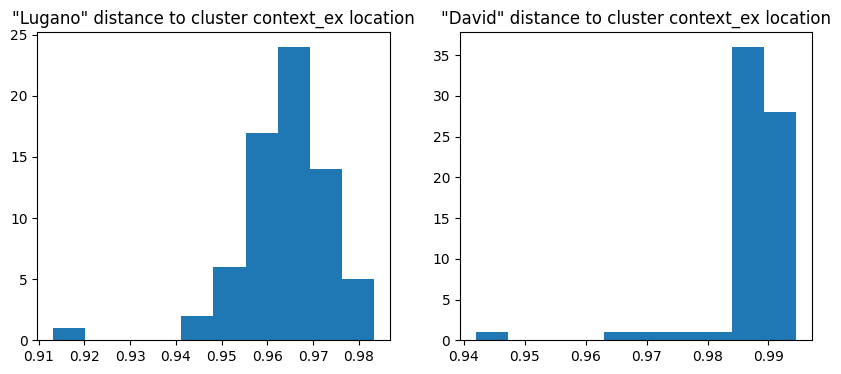

In [46]:
import matplotlib.pyplot as plt

idx = 54  # Lugano
idx = 35  # David
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(all_distances[54])
axes[0].set_title(f'"Lugano" distance to cluster {context_type} {sensitive_type}')

axes[1].hist(all_distances[35])
axes[1].set_title(f'"David" distance to cluster {context_type} {sensitive_type}')

plt.show()